In [1]:
from utils import *
from fluxtower_parse import *
from eddy_flux import * 
import numpy as np      
import datetime as dt
from scipy.signal import medfilt, detrend, coherence, windows
import os


In [2]:
# Save processed SHF and LHF data

# Input processed data location
d_loc = '/Volumes/Data/ICECAPSarchive/fluxtower/processed/'

# Output location
out_loc = '/Users/heather/ICECAPS-ACE/Processed/'

# Start and stop date:
start = dt.datetime(2019,7,29,0,0)
stop = dt.datetime(2019,8,1,0,0)

# Paramters
avp = 15 # averaging period (minutes)
sf = 10.0 # Metek sampling frequency (HZ)

# Days to loop through
days = pd.date_range(start,stop,freq='1D')

## Start loop ##
for day in days:
    day_str = str(day.date()) 
    print(day_str)
    times = pd.date_range(day, day+pd.Timedelta(hours=24),freq='15min')[0:-1]

    # Get metek data
    if os.path.isfile(d_loc+'metek/metek1_%s'%day_str):
        m1_orig = pd.read_csv(d_loc+'metek/metek1_%s'%day_str, index_col=0, parse_dates=[0])
        if m1_orig.empty:
            print('Error: File empty, '+day_str)
            continue
    else:
        print('Error: File empty, '+day_str)
        continue

    # Clean metek data 
    m1 = clean_metek(m1_orig)

    # Cross-wind temperature correction
    m1['T'] = Ts_sidewind_correction(m1['T'].astype(float),m1['x'].astype(float),m1['y'].astype(float),m1['z'].astype(float))

    # Rotate to average streamline for each 15 minute period. 
    m_rot = rotate_to_run(m1,avp)

    # Calculate sensible heat flux. 
    w = m_rot['w']
    T = m_rot['T']
    SHF,std=shf(w,T,avp)

    # Get licor data
    if os.path.isfile(d_loc+'LiCOR/licor_%s'%day_str):
        licor = pd.read_csv(d_loc+'LiCOR/licor_%s'%day_str, index_col=0, parse_dates=[0])
    else:
        print('Error: File empty, '+day_str)
        continue
              
    # Calculate latent heat flux
    T = licor['T']
    P = licor['P']
    Nconc = licor['H2OD']
    w = m_rot['w']
    try:
        LHF = lhf(w,T,P,Nconc,avp)
    except:
        print('No latent heat flux')
        LHF=list(np.full(len(times), np.nan))

    # Build dataframe
    flux_pro = pd.DataFrame(columns=['Dates', 'SHF', 'LHF'])
    flux_pro['Dates']=times
    flux_pro['SHF']=SHF
    flux_pro['LHF']=LHF
    flux_pro = flux_pro.set_index('Dates')

    # Save processed data
    #flux_pro.to_csv(out_loc+'FluxPro_%s'%day_str)

2019-07-29
2019-07-30
2019-07-31
2019-08-01


In [3]:
flux_pro

,SHF,LHF
Dates,,
2019-08-01 00:00:00,0.490807,-0.325758
2019-08-01 00:15:00,-1.584671,-1.300093
2019-08-01 00:30:00,-2.400300,NaN
2019-08-01 00:45:00,-3.118126,NaN
2019-08-01 01:00:00,-2.804807,NaN
...,...,...
2019-08-01 22:45:00,-3.066539,-0.634780
2019-08-01 23:00:00,-3.628713,-0.697277
2019-08-01 23:15:00,-2.619715,-0.312132


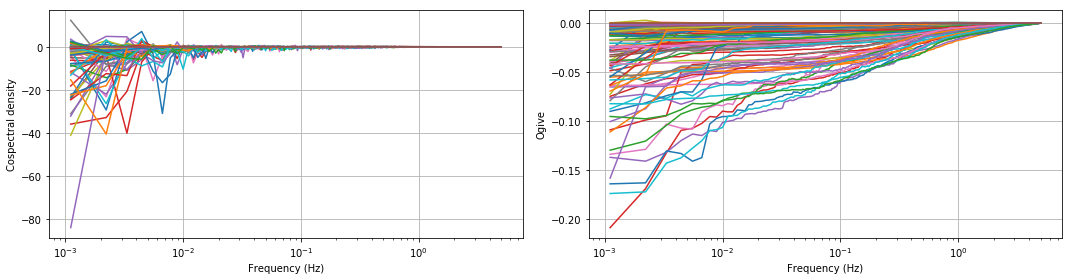

In [ ]:
# Plot co spectral density and ogive function.

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(121)
ax1.grid(True)
for i in range(0,len(f)):
    ax1.semilogx(f[i],Csdxy[i],label='cospectra')
ax1.set_ylabel('Cospectral density')
ax1.set_xlabel('Frequency (Hz)')
#ax1.legend()

ax2 = fig.add_subplot(122)
ax2.grid(True)
for i in range(0,len(f)):
    ax2.semilogx(f[i],ogive[i],label='ogive function')
ax2.set_ylabel('Ogive')
ax2.set_xlabel('Frequency (Hz)')
#ax2.legend()

#ax.set_xlim(d1,d2)
fig.tight_layout()



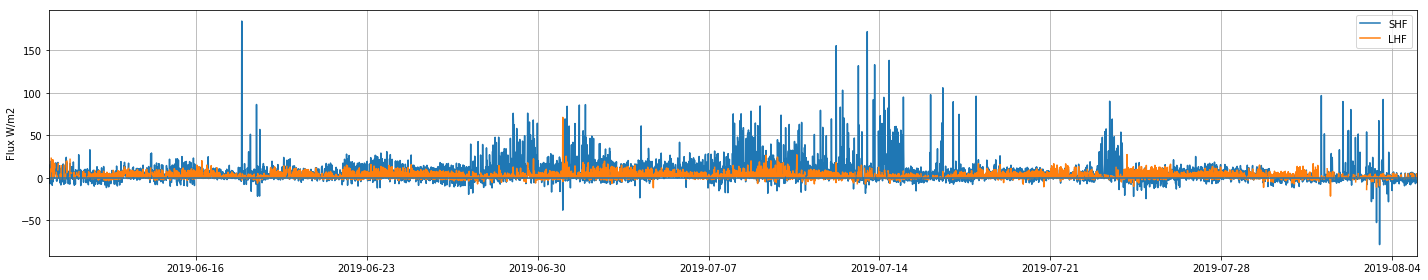

In [2]:
# Get proccessed data and plot fluxes

flux_loc = '/Users/heather/ICECAPS-ACE/Processed/'

# Start and stop date:
start = dt.datetime(2019,6,10,0,0)
stop = dt.datetime(2019,8,5,0,0)

# Days to loop through
days = pd.date_range(start,stop,freq='1D')
flux_pro = pd.DataFrame(columns=['Dates', 'SHF', 'LHF'])
for day in days: 
    day_str = str(day.date())
    if os.path.isfile(flux_loc+'FluxPro_%s'%day_str):
        day_flux = pd.read_csv(flux_loc+'FluxPro_%s'%day_str, index_col=0, parse_dates=[0])
        flux_pro = flux_pro.append(day_flux)


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(111)
ax1.grid(True)
ax1.plot(flux_pro.index,flux_pro.SHF,label='SHF')
ax1.plot(flux_pro.index,flux_pro.LHF,label='LHF')
ax1.set_ylabel('Flux W/m2')
ax1.axhline(0)
#ax1.set_ylim(-200,200)
#ax1.set_xlabel('Frequency (Hz)')
#ax1.legend()

#ax2 = fig.add_subplot(212)
#ax2.grid(True)
#ax2.plot(plot_times,LHF)
#ax2.set_ylabel('LHF W/m2')
#ax2.axhline(0)
#ax1.set_xlabel('Frequency (Hz)')
ax1.legend()

ax1.set_xlim(start,stop)
fig.tight_layout()




In [12]:
# Sensible heat flux- correlates with wind speed/ humidity? 
# Latent heat flux correlates with sunny-ness/ cloudiness?

flux_pro.to_csv(out_loc+'All_flux_%s_to_%s'%(str(start.date()),str(start.date())))


In [ ]:
# Use snow depth sensor to do absolute height correction

In [1]:
# Calculate bulk richardson number
#Ri = richardson number
#Rig = gradient richardson number: 
#       provides a measure of the balance between shear and bouyant forces 
#       and the resultant turbulent state of the atmosphere, based on mean 
#       wind and thermodynamic profiles. Negative Rig is an indication of 
#       buoyancy-generated turbulence, positive values are associated with 
#       stably stratified turbulence.
# For simplicity, generally refer to Rig>1 as nonturbulent. 

# Rig = g/thetaV * (dthetaV/dz) / ((du/dz)**2 + (dv2/dz)**2)
# thetaV = virtual potential temperature

# Approximate thetav with theta (potential temperature) for now. 

# Constants
Rd = 287.0 # J/K/kg - gas constant of 1kg of dry air
P0 = 100000.0 # Standard reference pressure, Pa
g = 9.8 # m/s, gravitational acceleration.
cp = 1005.7 # j/kg/K, assuming dry air at 273K

# theta = T(P0/P)**(Rd/cp)

# We need: 
# M1, winds and T
# M2, winds and T 

# Difference between M1 and M2
dz = 11.3 # m




In [3]:
# Plots to look at melt event. 

# Plotting preferences

rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams.update({'font.size': 14}) 
rcParams['axes.titlepad'] = 14 
rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'
myFmt = md.DateFormatter('%d-%m')
rule = md.DayLocator(interval=5)

# Melt events: June 12th and July 30th

# Start and stop date:
start = dt.datetime(2019,6,10,0,0)
stop = dt.datetime(2019,8,5,0,0)

# Days to loop through
days = pd.date_range(start,stop,freq='1D')

br=[]
fluxes=[]
wspd=[]
temps=[]
KT=[]
SND=[]
CPC=[]


# Get turbulent fluxes
flux_loc = '/Users/heather/ICECAPS-ACE/Processed/'
flux_pro = pd.DataFrame(columns=['Dates', 'SHF', 'LHF'])
for day in days: 
    day_str = str(day.date())
    if os.path.isfile(flux_loc+'FluxPro_%s'%day_str):
        day_flux = pd.read_csv(flux_loc+'FluxPro_%s'%day_str, index_col=0, parse_dates=[0])
        flux_pro = flux_pro.append(day_flux)
        
# Get snow depth
snd_loc = '/Volumes/Data/ICECAPSarchive/fluxtower/processed/SnD/'
snd = pd.DataFrame(columns=['Date','C','Q','V','depth','diff','HMP1_T','depth_Tcorrected'])
for day in days: 
    day_str = str(day.date())
    if os.path.isfile(snd_loc+'snd_%s'%day_str):
        day_dat = pd.read_csv(snd_loc+'snd_%s'%day_str, index_col=0, parse_dates=[0])
        snd = snd.append(day_dat)
        
# Get KT
kt_loc = '/Volumes/Data/ICECAPSarchive/fluxtower/processed/KT/'
kt = pd.DataFrame(columns=['Date','T','Units'])
for day in days: 
    day_str = str(day.date())
    if os.path.isfile(kt_loc+'KT_%s'%day_str):
        day_dat = pd.read_csv(kt_loc+'KT_%s'%day_str, index_col=0, parse_dates=[0])
        kt = kt.append(day_dat)
kt = kt[~kt.index.duplicated()]

In [4]:
# Get HMP
hmp_names=['HMP1','HMP2','HMP3','HMP4']
hmp_loc = '/Volumes/Data/ICECAPSarchive/fluxtower/processed/HMP/'
hmp = pd.DataFrame(columns=['Date','RH','Ta','Tw','Err','h'])
all_hmps=[]
for i in range(0,len(hmp_names)): 
    name=hmp_names[i]
    for day in days: 
        day_str = str(day.date())
        if os.path.isfile(hmp_loc+'%s_%s'%(name,day_str)):
            day_dat = pd.read_csv(hmp_loc+'%s_%s'%(name,day_str), index_col=0, parse_dates=[0])
            hmp = hmp.append(day_dat)
    hmp = hmp[~hmp.index.duplicated()]
    hmp = hmp.sort_index()
    all_hmps.append(hmp)
                         
hmp1 = all_hmps[0]['Ta']
hmp2 = all_hmps[1]['Ta']
hmp3 = all_hmps[2]['Ta']
hmp4 = all_hmps[3]['Ta']                      

In [5]:
# Get V2
v2_loc = '/Volumes/Data/ICECAPSarchive/fluxtower/processed/ventus/'
v2 = pd.DataFrame(columns=['Date','wsd','wdir','T','Checksum','status'])
for day in days: 
    day_str = str(day.date())
    if os.path.isfile(v2_loc+'v2_%s'%day_str):
        day_dat = pd.read_csv(v2_loc+'v2_%s'%day_str, index_col=0, parse_dates=[0])
        v2 = v2.append(day_dat)
v2 = v2[~v2.index.duplicated()]

In [6]:
# Subsample v2 and temps so they're easier to plot, - minutely?

v2_minutely = v2['wsd'].resample('1T').mean()
hmp1_min = hmp1.resample('1T').mean()
hmp2_min = hmp2.resample('1T').mean()
hmp3_min = hmp3.resample('1T').mean()
hmp4_min = hmp4.resample('1T').mean()


In [7]:
# Get CPC
cpc_loc = '/Volumes/Data/ICECAPSarchive/ace/Extracted/CPC/'
cpc = pd.DataFrame()
for day in days: 
    day_str = str(day.date())
    if os.path.isfile(cpc_loc+'CPC_Summit_%s.csv'%day_str):
        cpc = cpc.append(pd.read_csv(cpc_loc+'CPC_Summit_%s.csv'%day_str,sep=',',error_bad_lines=False,header=None,parse_dates={'Dates' : [0,1,2,3,4,5]}))  

cpc.Dates = pd.to_datetime(cpc.Dates,format='%Y %m %d %H %M %S')
cpc = cpc.sort_values('Dates')
cpc = cpc.set_index(cpc['Dates'])
cpc.index = pd.DatetimeIndex(cpc.index)
del cpc['Dates']
cpc_counts =cpc.rename(columns={6:'Concentration (/cm3)'})


In [8]:
# Subsample cpc minutely too. 
cpc_min = cpc_counts['Concentration (/cm3)'].resample('1T').mean()

In [14]:
# Subplots: Bulk rich? , fluxes, wspd, T, KT, SND, aerosol count 
fluxes=[flux_pro['SHF'],flux_pro['LHF']]
SND=[snd['depth_Tcorrected']]
KT=[kt['T']]
temps =[hmp1_min,hmp2_min,hmp3_min,hmp4_min]
CPC=[cpc_min]
wspd = [v2_minutely]

plot_vars=[br,fluxes,wspd,temps,KT,SND,CPC]
colours = ['C0','C1','C2','C3']
labels=[['BRN'],['SHF','LHF'],['Ventus2'],['2m','4m','9m','15m'],['KT15'],['Snow depth sensor'],['CPC']]
ylabels=['BRN','Turbulent flux (W/m2)','9m Wind speed (m/s)','Air T (C)','Snow surface T (C)','Distance to surface (m)','Total aerosol concentration (cc)']
ymin=[0,0,0,0,0,0,0]
ymax=[200,200,200,200,200,200,200]

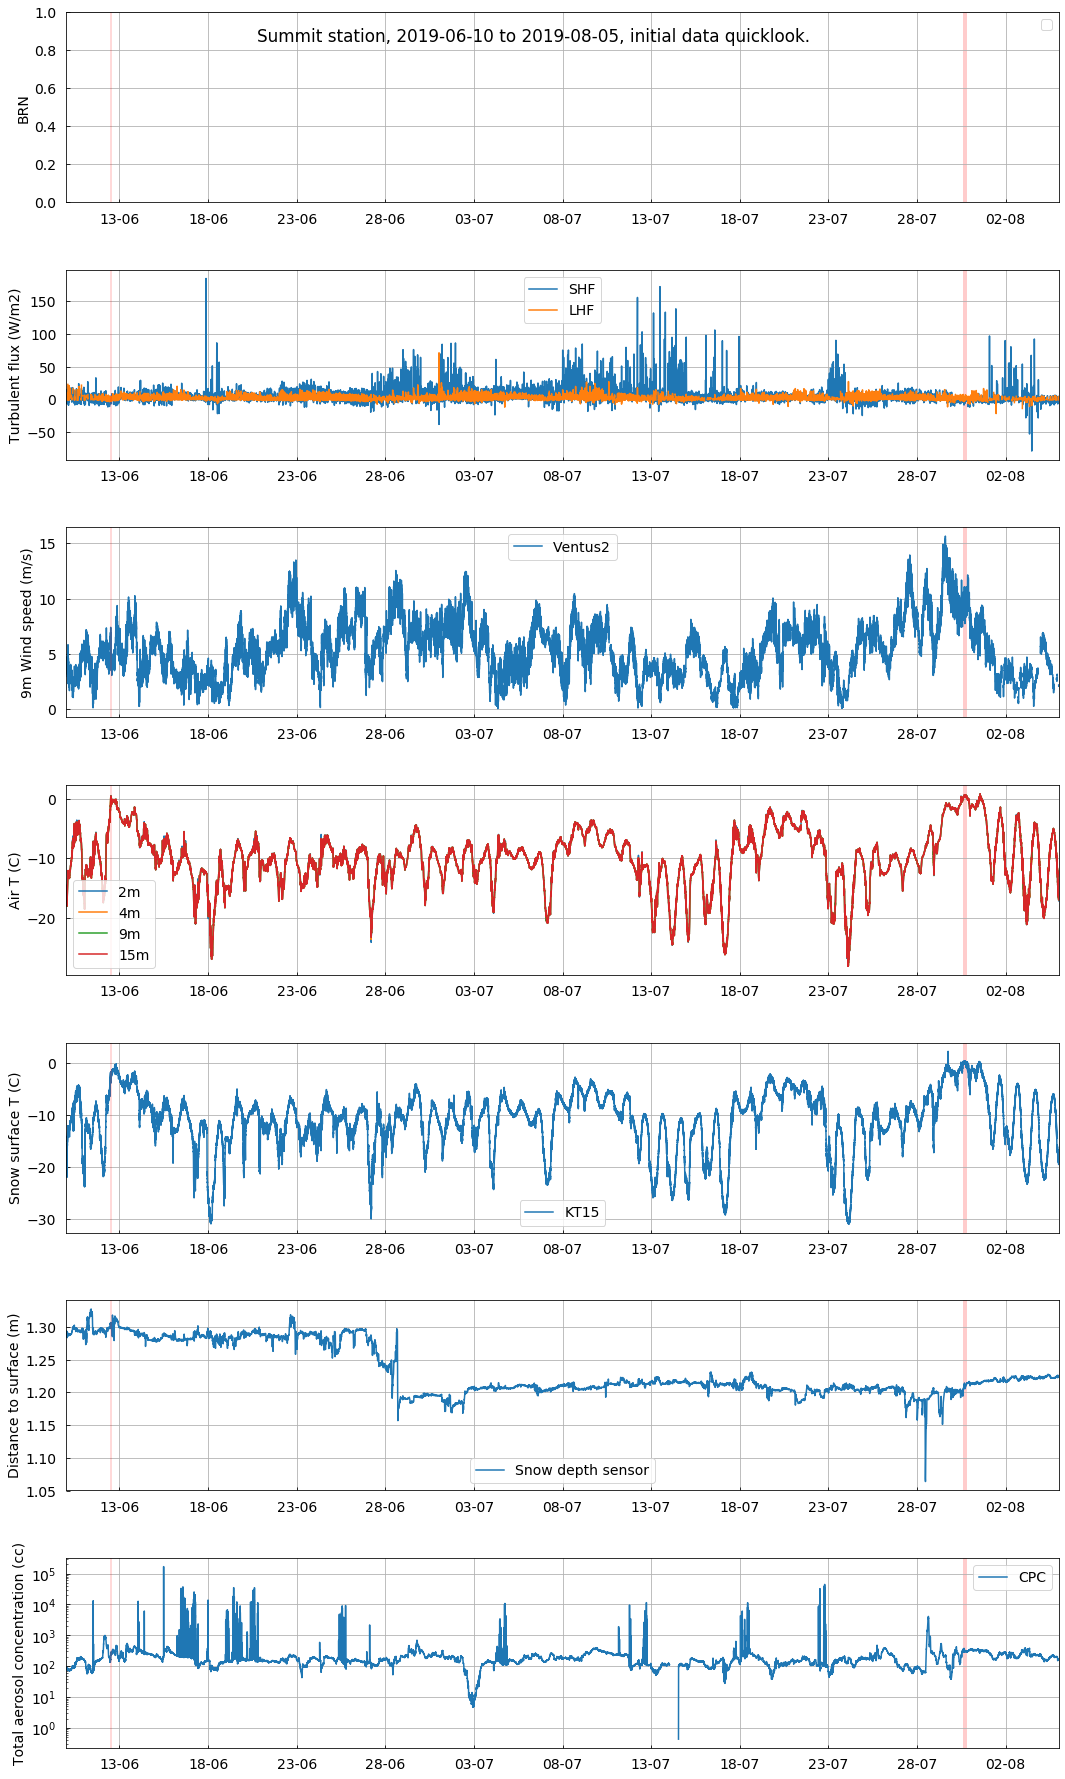

In [22]:
fig, axs = plt.subplots(7,figsize=(15,25))
fig.suptitle('Summit station, %s to %s, initial data quicklook.'%(str(start.date()),str(stop.date())))
for i in range(0,len(axs)):
    var = plot_vars[i]
    for j in range(0,len(var)):
        if i==6:
            axs[i].semilogy(var[j],label=labels[i][j])
        else:
            axs[i].plot(var[j],label=labels[i][j],c=colours[j])
        
    axs[i].grid(True)
    axs[i].set_ylabel(ylabels[i])
    axs[i].set_xlim(start,stop)
    axs[i].legend()
    axs[i].xaxis.set_major_formatter(myFmt)
    axs[i].xaxis.set_major_locator(rule) 
    axs[i].axvspan(dt.datetime(2019,7,30,15,0,0),dt.datetime(2019,7,30,19,41,0),ymin=ymin[i],ymax=ymax[i],facecolor='r',alpha=0.2)
    axs[i].axvline(dt.datetime(2019,6,12,13,0,0),c='r',alpha=0.2)
fig.tight_layout()

In [17]:
min(CPC[0])

0.4342857142857143